In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import numpy as np 
from tqdm.notebook import tqdm 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

# Load

In [4]:
transforms_simple = T.Compose([
    T.ToTensor(), 
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=512,
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=512,
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=512,
    shuffle=True,
    num_workers=16
)

In [5]:
mean = torch.zeros(3, dtype=float)
mean_sq = torch.zeros(3, dtype=float)
n = len(train_loader)

for x, _ in train_loader:
    mean += torch.mean(x, dim=(0, 2, 3))
    mean_sq += torch.mean(x ** 2, dim=(0, 2, 3))

mean /= n
mean_sq /= n
std = torch.sqrt(mean_sq - mean ** 2)

In [6]:
mean

tensor([0.4803, 0.4481, 0.3976], dtype=torch.float64)

In [7]:
std

tensor([0.2770, 0.2691, 0.2821], dtype=torch.float64)

In [8]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [9]:
num_classes = len(train_folder.class_to_idx)

# Model

In [12]:
# class CNNBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, pool=True):
#         super(CNNBlock, self).__init__()

#         ### YOUR CODE HERE
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(2) if pool else nn.Identity()
#         ### END OF YOUR CODE

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         return x

In [13]:
# model = nn.Sequential(
#     CNNBlock(3, 64),
#     CNNBlock(64, 128),
#     CNNBlock(128, 256),
#     CNNBlock(256, 512),
#     CNNBlock(512, 1024),
#     # # v NOTE THIS
#     nn.AdaptiveAvgPool2d((1, 1)),  # B x 512 x 1 x 1
#     # # ^ NOTE THIS ^
#     nn.Flatten(),  # B x 512
#     nn.Linear(1024, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, 512),
#     nn.ReLU(),
#     nn.Linear(512, 200),
# )

In [24]:
import torch
import torch.nn as nn

class ComplexCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create an instance of the model
model = ComplexCNN(num_classes=200)


# Wandb

# Train

In [43]:
import wandb

config = {
    "learning_rate": 3e-4,
    "weight_decay": 0.05,
    "batch_size": 512,
    "num_epochs": 25,
    "optimizer": torch.optim.AdamW,
}

wandb.init(
    # set the wandb project where this run will be logged
    project="hw2",
    name="ChatGPT",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)


In [26]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [27]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [28]:
transforms_simple = T.Compose([
    T.ToTensor(), 
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=15),
    T.Normalize(mean, std) # по-хорошему нужно брать из датасета
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"], 
    weight_decay=config["weight_decay"]
)

In [30]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)

    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

In [31]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)


def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

In [42]:
def run_experiment(
    model, dataloader_train, dataloader_val, 
    loss_fn, optimizer, num_epochs, 
    device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model


In [33]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_chatgpt",
)

epoch: 000 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 000 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=00_valloss=4.783.pth.tar



epoch: 001 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 001 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=01_valloss=4.322.pth.tar



epoch: 002 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 002 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=02_valloss=3.967.pth.tar



epoch: 003 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 003 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=03_valloss=3.902.pth.tar



epoch: 004 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 004 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=04_valloss=3.674.pth.tar



epoch: 005 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 005 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 006 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 006 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=06_valloss=3.637.pth.tar



epoch: 007 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 007 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 008 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 008 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=08_valloss=3.544.pth.tar



epoch: 009 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 009 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=09_valloss=3.420.pth.tar



epoch: 010 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 010 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 011 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 011 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 012 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 012 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=12_valloss=3.375.pth.tar



epoch: 013 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 013 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=13_valloss=3.307.pth.tar



epoch: 014 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 014 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 015 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 015 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 016 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 016 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 017 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 017 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=17_valloss=3.189.pth.tar



epoch: 018 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 018 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=18_valloss=3.167.pth.tar



epoch: 019 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 019 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 020 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 020 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=20_valloss=3.146.pth.tar



epoch: 021 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 021 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 022 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 022 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 023 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 023 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 024 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 024 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=24_valloss=3.085.pth.tar

Best val_loss = 3.085 reached at epoch 24


In [34]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_loss_train,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch_loss_val,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
epoch_loss_train,3.45876
epoch_loss_val,3.08532
loss,3.49877
lr,0.0003


In [44]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_chatgpt",
    start_epoch=config["num_epochs"]
)

epoch: 025 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 025 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=25_valloss=3.086.pth.tar



epoch: 026 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 026 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 027 | train:   0%|          | 0/196 [00:00<?, ?it/s]

epoch: 027 | val  :   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 028 | train:   0%|          | 0/196 [00:00<?, ?it/s]

In [35]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

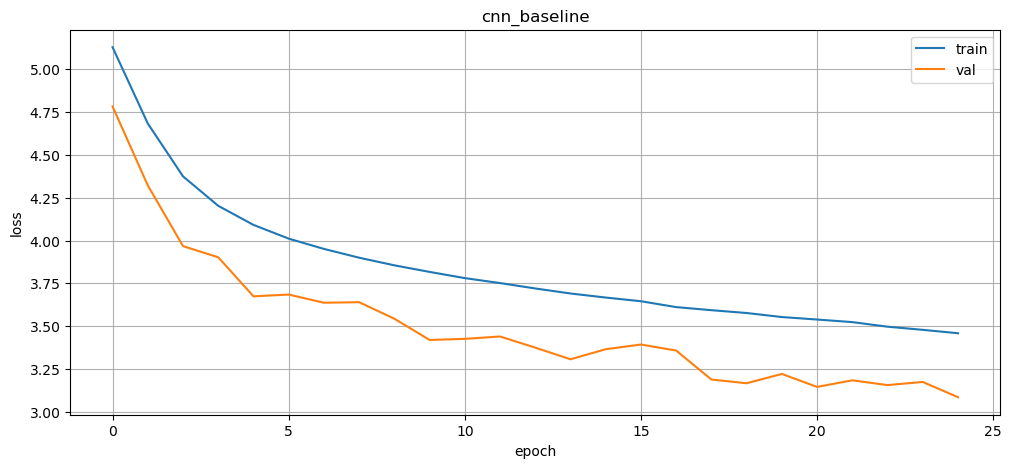

In [36]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

In [37]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [38]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, train_loader, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/196 [00:00<?, ?it/s]

0.31673

In [39]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, test_loader, device)

accuracy_train = accuracy_score(test_labels, test_preds)
accuracy_train

  0%|          | 0/20 [00:00<?, ?it/s]

0.0047

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns